Magnetization Reconstruction
Copyright (C) 2024  Changyu Yao

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Result visualization

**Run the cell below to import necessary libraries and functions.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
pi = np.pi

def spinRegionLoad(weight):

    points = np.column_stack(np.where(weight == 1))
    listX, listY = [],[]
    mPixelX, mPixelY = weight.shape
    NofP = len(points)
    for i in range(NofP):
        listX.append(points[i][0])
        listY.append(points[i][1])
    listX, listY = np.array(listX), np.array(listY)

    return mPixelX, mPixelY, NofP, listX, listY, weight

class visualizor:
    def __init__(self, **kwargs):
        if 'weight' in kwargs:
            self.mPixelX, self.mPixelY, self.NofP, self.listX, self.listY, self.weight = spinRegionLoad(kwargs['weight'])
        else:
            self.mPixelX, self.mPixelY, self.NofP, self.listX, self.listY, self.weight = spinRegionLoad(np.load(kwargs['weightFile']))
        if 'mRes' in kwargs:
            self.mRes = kwargs['mRes']
        else:
            self.mRes = np.load(kwargs['mResFile'])
        if 'center' in kwargs:
            if type(kwargs['center'][0]) == float:
                self.center = np.array([self.mPixelX*kwargs['center'][0], self.mPixelY*kwargs['center'][1]])
            else:
                self.center = np.array(kwargs['center'])
        else:
            self.center = np.array([self.mPixelX/2, self.mPixelY/2])
        self.theta_r = kwargs.get('theta_r', lambda r: pi/2)
    
    def generateArrows(self, shape, stride, normalization):
        arrowDict = {}
        if shape == 'flat':
            for i in range(0, self.mPixelX, stride):
                for j in range(0, self.mPixelY, stride):
                    if self.weight[i,j] == 1:
                        arrowDict[(i,j)] = self.mRes[i,j,:]/normalization
        elif shape =='sphere':
            for i in range(0, self.mPixelX, stride):
                for j in range(0, self.mPixelY, stride):
                    if self.weight[i,j] == 1:
                        (x,y) = np.array([i,j]) - self.center
                        r = np.linalg.norm(np.array([i,j]) - self.center)
                        theta = self.theta_r(r)
                        # calculate phi
                        if x == 0:
                            if y > 0:
                                phi = pi/2
                            else:
                                phi = 3*pi/2
                        elif x > 0:
                            phi = np.arctan(y/x)
                        else:
                            phi = pi + np.arctan(y/x)
                        arrowDict[(theta,phi)] = self.mRes[i,j,:]/normalization
        return arrowDict

    def plotRegion(self, **kwargs):
        normalization = kwargs.get('normalization', np.max(np.linalg.norm(self.mRes, axis=2)))
        stride = kwargs.get('stride', 1)
        shape = kwargs.get('shape', 'flat')
        arrowDict = self.generateArrows(shape, stride, normalization)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        if shape == 'flat':
            # flat canvas
            regionStride = kwargs.get('regionStride', 1)
            if 'crop' in kwargs:
                if type(kwargs['crop'][0][0]) == int:
                    xStart = kwargs['crop'][0][0]
                    xEnd = kwargs['crop'][0][1]
                    yStart = kwargs['crop'][1][0]
                    yEnd = kwargs['crop'][1][1]
                elif type(kwargs['crop'][0][0]) == float:
                    xStart = round(self.mPixelX*kwargs['crop'][0][0])
                    xEnd = round(self.mPixelX*kwargs['crop'][0][1])
                    yStart = round(self.mPixelY*kwargs['crop'][1][0])
                    yEnd = round(self.mPixelY*kwargs['crop'][1][1])
                canvasScale = max(xEnd-xStart, yEnd-yStart)
            else:
                xStart = 0
                xEnd = self.mPixelX
                yStart = 0
                yEnd = self.mPixelY
                canvasScale = max(self.mPixelX, self.mPixelY)
            zStart = -canvasScale/2
            zEnd = canvasScale/2         
            surfaceColor = kwargs.get('surfaceColor', (0.5,0.5,0.5,0.4))
            if surfaceColor is not None:
                X = [xStart-0.5, xEnd+0.5, xEnd+0.5, xStart-0.5]
                Y = [yStart-0.5, yStart-0.5, yEnd+0.5, yEnd+0.5]
                Z = [0, 0, 0, 0]
                ax.plot_trisurf(X, Y, Z, color=surfaceColor, linewidth=0.5)
            regionColor = kwargs.get('regionColor', (1,0,0,0.8))
            for i in range(xStart, xEnd, regionStride):
                for j in range(yStart, yEnd, regionStride):
                    X = [i-0.5*regionStride, i+0.5*regionStride, i+0.5*regionStride, i-0.5*regionStride]
                    Y = [j-0.5*regionStride, j-0.5*regionStride, j+0.5*regionStride, j+0.5*regionStride]
                    Z = [0, 0, 0, 0]
                    if self.weight[i,j] == 1:
                        ax.plot_trisurf(X, Y, Z, color=regionColor, linewidth=0.5)

            # arrows
            arrowColorMap = kwargs.get('arrowColorMap', plt.cm.Spectral)
            arrowColorFunction = kwargs.get('arrowColorFunction', lambda x: x[0])
            maxV = np.max(np.abs(np.apply_along_axis(arrowColorFunction,axis=2,arr=self.mRes)))
            arrowColorNorm = kwargs.get('arrowColorNorm', colors.Normalize(vmin=-maxV, vmax=maxV))
            arrowScale = kwargs.get('arrowScale', 1)
            for key, value in arrowDict.items():
                ax.quiver(key[0]-value[0]*stride*arrowScale*1.0,
                          key[1]-value[1]*stride*arrowScale*1.0,
                          -value[2]*stride*arrowScale*1.0,
                          value[0]*stride*2.0*arrowScale,
                          value[1]*stride*2.0*arrowScale,
                          value[2]*stride*2.0*arrowScale,
                          normalize=False,
                          color=arrowColorMap(arrowColorNorm(arrowColorFunction(value*normalization))))   

        elif shape =='sphere':
            # sphere canvas
            radius = kwargs.get('radius', 10)
            xStart = -radius
            xEnd = radius
            yStart = -radius
            yEnd = radius
            zStart = -radius
            zEnd = radius
            surfaceColor = kwargs.get('surfaceColor', (0.5,0.5,0.5,0.4))
            if surfaceColor is not None:
                u, v = np.mgrid[0:2*pi:20j, 0:pi:10j]
                x = np.cos(u)*np.sin(v)*radius
                y = np.sin(u)*np.sin(v)*radius
                z = np.cos(v)*radius
                ax.plot_surface(x, y, z, color=surfaceColor, alpha=0.2)
            
            # arrows
            arrowColorMap = kwargs.get('arrowColorMap', plt.cm.winter)
            arrowColorFunction = kwargs.get('arrowColorFunction', lambda x: x[2])
            maxV = np.max(np.abs(np.apply_along_axis(arrowColorFunction,axis=2,arr=self.mRes)))
            arrowColorNorm = kwargs.get('arrowColorNorm', colors.Normalize(vmin=-maxV, vmax=maxV))
            arrowScale = kwargs.get('arrowScale', 1)
            for key, value in arrowDict.items():
                theta, phi = key
                x = np.sin(theta)*np.cos(phi)*radius
                y = np.sin(theta)*np.sin(phi)*radius
                z = np.cos(theta)*radius
                ax.quiver(x-value[0]*stride*arrowScale*1.0,
                          y-value[1]*stride*arrowScale*1.0,
                          z-value[2]*stride*arrowScale*1.0,
                          value[0]*stride*2.0*arrowScale,
                          value[1]*stride*2.0*arrowScale,
                          value[2]*stride*2.0*arrowScale,
                          normalize=False,
                          color=arrowColorMap(arrowColorNorm(arrowColorFunction(value*normalization))))

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(xStart, xEnd)
        ax.set_ylim(yStart, yEnd)
        ax.set_zlim(zStart, zEnd)
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=arrowColorNorm, cmap=arrowColorMap), ax=ax)
        colorbarTitle = kwargs.get("colorbarTitle", "$M_x$" if shape == "flat" else "$M_z$")
        cbar.set_label(colorbarTitle)
        ax.view_init(kwargs.get('view_elev', 30), kwargs.get('view_azim', -116))
        plt.title(kwargs.get('title', ''))
        saveTo = kwargs.get('saveTo', None)
        showAxis = kwargs.get('showAxis', False)
        showGrid = kwargs.get('showGrid', False)
        if (not showAxis):
            ax.set_axis_off()
        if (not showGrid):
            ax.grid(False)
        if saveTo is not None:
            plt.savefig(saveTo, dpi=600)
            plt.close(fig)
        else:
            plt.show()

    def __call__(self, **kwargs):
        self.plotRegion(**kwargs)


## Create a visualizor
Use `weight: np.ndarray` (2D array from save region option) or `weightFile: str` to specify the spin region.
Use `mRes: np.ndarray` (3D array from save M option) or `mResFile: str` to load the magnetization data.

If you want to plot on a sphere, you need to provide the center and a theta-r function.
`center: (x,y)` is the center point of the region. It can be `int` that represents position in pixel unit, or `float` that represents the relative position. Default value is (0.5,0.5).
`theta_r: r -> theta` is a function that maps the distance from the center to the angle on the sphere. It takes a distance r (in pixel unit) and returns the angle theta (in radian).

In [2]:
Skyrmion = visualizor(weightFile='examples/charge.npy',
                      mResFile='examples/skyrmion.npy',
                      theta_r=lambda r: pi*(r*3/32)**2)
Ferro = visualizor(weightFile='examples/single.npy',
                    mResFile='examples/ferro.npy')
Meron = visualizor(weightFile='examples/charge.npy',
                   mResFile='examples/meron.npy',
                   theta_r=lambda r: pi*(r*3/64))

mRes_skyrmion = np.load('examples/skyrmion.npy')
mRes_antiskyrmion = mRes_skyrmion
mRes_antiskyrmion[:,:,-1] = -mRes_antiskyrmion[:,:,-1]
Antiskyrmion = visualizor(weightFile='examples/charge.npy',
                          mRes=mRes_antiskyrmion,
                          theta_r=lambda r: pi*(r*3/32)**2)

## Plot the magnetization
To plot the magnetization, you can directly call your visualizor. By default, it will plot the magnetization in a flat view. You can change view by adding `shape="sphere"`.

A plot is consisted of three parts:

- **Spin region**:
  - Region sampling stride `regionStride: int`, default is `1`, which means the resolution of region sampling is 1. Down sampling can reduce the complexity when plotting huge region.
  - Surface color `surfaceColor` is the color of x-y plane or sphere surface, default is `(0.5,0.5,0.5,0.4)`.
  - Region color `regionColor` is the color of spin region, default is `(1,0,0,0.8)`. **It won't be used in sphere view.**
  - Sampling range `crop: ((xi, xf), (yi, yf))` defines the range of the plot. It can be `int` or `float`. Default is `((0.0, 1.0), (0.0, 1.0))`
  - `radius: float`, default is `10`, defines the radius of the sphere. **It will only be used in sphere view.**
- **Magnetization**:
  - `stride: int`, default is `1`, defines the sampling stride of magnetization.
  - `arrowScale: float`, default is `1`, defines the scale of the arrow.
  - Arrow length is normalized by `normalization: float`, default is max length of `mRes`.
  - `arrowColorMap` is the colormap of the arrow, default is `matplotlib.cm.Spectral` for flat view and `matplotlib.cm.winter` for sphere view.
  - `arrowColorFunction: np.ndarray -> float` decides the color of the arrow based on the magnetization value. Default is `lambda x: x[0]` for flat view and `lambda x: x[2]` for sphere view.
  - `arrowColorNorm` is the normalization function of the arrow color, default is `matplotlib.colors.Normalize(vmin=-vm, vmax=vm)` where `vm` is the maximum absolute value of `arrowColorFunction`.
  - `colorbarTitle: str` is the title of the colorbar. Default is `"$M_x$"` for flat view and `"$M_z$"` for sphere view.
- **Figure**:
  - `title: str` is the title of the plot.
  - `view_elev` and `view_azim` are the elevation and azimuth angle of the viewpoint.
  - If you want to show the axes, set `showAxis` to `True`.
  - If you want to show the background grid, set `showGrid` to `True`.
  - Depending on your preference for displaying the plot, you can use the `saveTo: str` parameter to save the plot to a file. Otherwise, `plt.show()` will be called to display it.

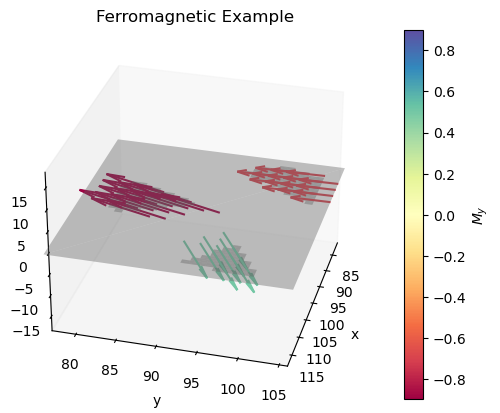

In [3]:
Ferro(shape='flat', regionStride=1, regionColor=(0.5,0.5,0.5,0.4), surfaceColor=(0.5,0.5,0.5,0.4), crop=((0.42,0.61),(0.4,0.55)),
      stride=2, arrowScale=2, arrowColorFunction = lambda x : x[1], colorbarTitle = "$M_y$",
      title = "Ferromagnetic Example", view_elev=30, view_azim=15, showAxis = True)

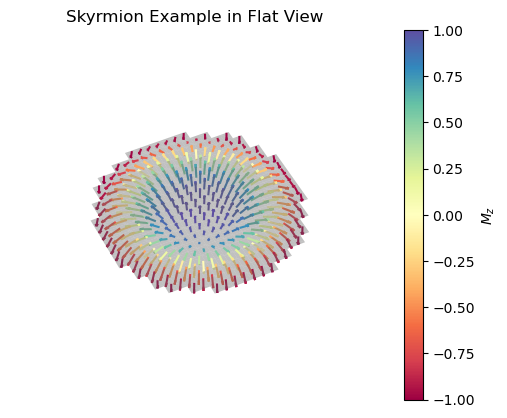

In [4]:
Skyrmion(shape='flat', regionStride=1, regionColor=(0.5,0.5,0.5,0.4), surfaceColor=(0.5,0.5,0.5,0.0), crop=((0.44,0.56),(0.44,0.56)),
         stride=1, arrowScale=0.8, arrowColorFunction=lambda x:x[2], colorbarTitle="$M_z$",
         title = "Skyrmion Example in Flat View", view_elev=48, view_azim=-116)

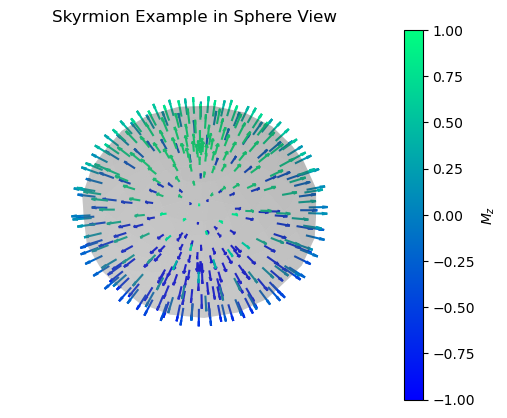

In [5]:
Skyrmion(shape='sphere', surfaceColor=(0.5,0.5,0.5,0.4), crop=((0.44,0.56),(0.44,0.56)),
         stride=1, arrowScale=0.8, arrowColorFunction = lambda x : x[2],
         title = "Skyrmion Example in Sphere View", view_elev=48, view_azim=-116)

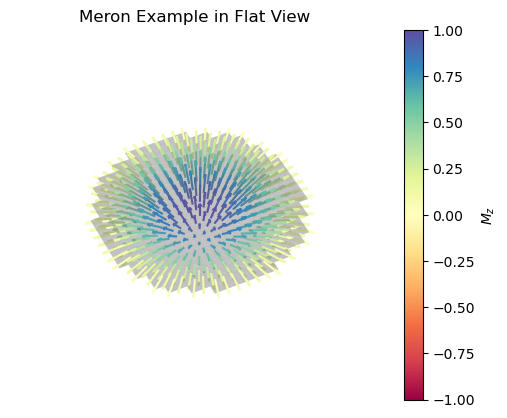

In [6]:
Meron(shape='flat', regionStride=1, regionColor=(0.5,0.5,0.5,0.4), surfaceColor=(0.5,0.5,0.5,0.0), crop=((0.44,0.56),(0.44,0.56)),
      stride=1, arrowScale=1.2, arrowColorFunction=lambda x:x[2], colorbarTitle="$M_z$",
      title = "Meron Example in Flat View", view_elev=48, view_azim=-116)

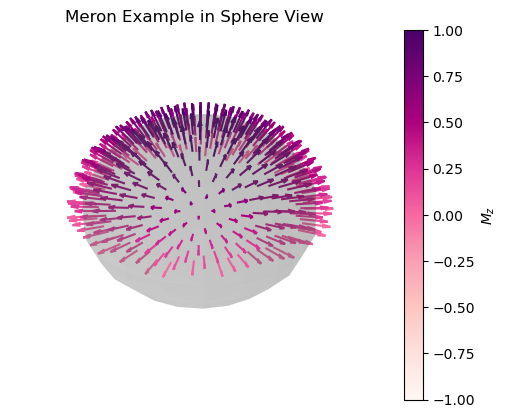

In [7]:
Meron(shape='sphere', surfaceColor=(0.5,0.5,0.5,0.4), crop=((0.44,0.56),(0.44,0.56)),
      stride=1, arrowScale=1.2, arrowColorMap=plt.cm.RdPu,
      title = "Meron Example in Sphere View", view_elev=30, view_azim=-116)

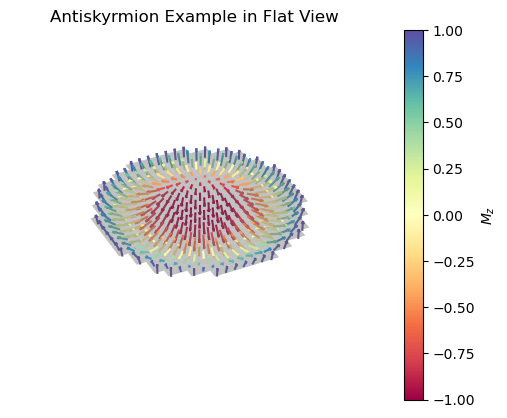

In [8]:
Antiskyrmion(shape='flat', regionStride=1, regionColor=(0.5,0.5,0.5,0.4), surfaceColor=(0.5,0.5,0.5,0.0), crop=((0.44,0.56),(0.44,0.56)),
         stride=1, arrowScale=0.8, arrowColorFunction=lambda x:x[2], colorbarTitle="$M_z$",
         title = "Antiskyrmion Example in Flat View", view_elev=36, view_azim=-116)

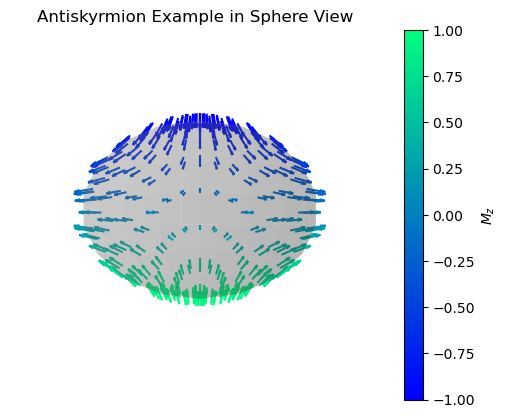

In [9]:
Antiskyrmion(shape='sphere', surfaceColor=(0.5,0.5,0.5,0.4), crop=((0.44,0.56),(0.44,0.56)),
         stride=1, arrowScale=0.8, arrowColorFunction = lambda x : x[2],
         title = "Antiskyrmion Example in Sphere View", view_elev=0, view_azim=0)